In [1]:
import json
import os
import collections

results_dir = "../../results/results_pairs/reranking"

drug_ranks = collections.defaultdict(list)
for round in [0, 1, 2]:
    json_dir = os.path.join(results_dir, "responses", f"round_{round}", "json")
    for fn in os.listdir(json_dir):
        if not fn.endswith(".json"):
            continue
        json_path = os.path.join(json_dir, fn)
        with open(json_path, "r") as f:
            data = json.load(f)
        drug_name = fn.split(".json")[0]
        genes = [d["gene"] for d in data][:10]
        drug_ranks[drug_name] += [genes]

['Amodiaquine' 'Artemether' 'Artesunate' 'Bedaquiline' 'Capreomycin'
 'Chloroquine' 'Clindamycin' 'Clofazimine' 'Cycloserine' 'Delamanid'
 'Dihydroartemisinin' 'Doxycycline' 'Ethambutol' 'Ethionamide' 'Isoniazid'
 'Levofloxacin' 'Linezolide' 'Lumefantrine' 'Mefloquine' 'Moxifloxacin'
 'P-aminosalicylic acid' 'Piperaquine' 'Pretomanid' 'Primaquine'
 'Pyrazinamide' 'Pyrimethamine' 'Quinine' 'Rifampin' 'Rifapentine'
 'Streptomycin' 'Sulfadoxine' 'Terizidone']


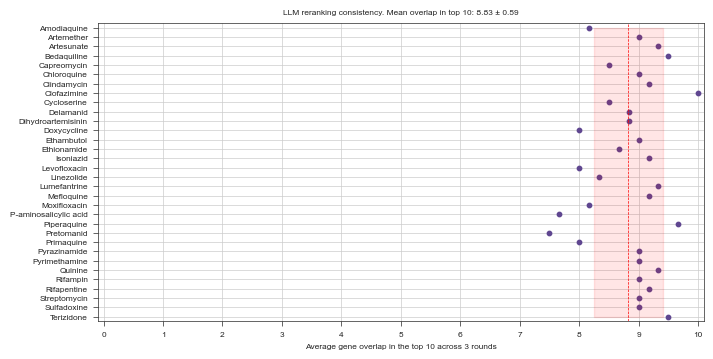

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import stylia

drug_consensus = {}
json_dir = os.path.join(results_dir, "consensus", "json")
for fn in os.listdir(json_dir):
    if not fn.endswith(".json"):
        continue
    json_path = os.path.join(json_dir, fn)
    with open(json_path, "r") as f:
        data = json.load(f)
    drug_name = fn.split(".json")[0]
    genes = [d["gene"] for d in data][:10]
    drug_consensus[drug_name] = genes

R = []
drug_names = []
for k,v in drug_ranks.items():
    drug_names += [k.capitalize()]
    overlaps = []
    for i, x in enumerate(v):
        for j, y in enumerate(v):
            if i < j:
                continue
            overlap = len(set(x) & set(y))
            overlaps += [overlap]
    avg_overlap = sum(overlaps) / len(overlaps)
    cons_overlaps = []
    for i, x in enumerate(v):
        overlap = len(set(x) & set(drug_consensus[k]))
        cons_overlaps += [overlap]
    avg_cons_overlap = sum(cons_overlaps) / len(cons_overlaps)
    R += [[avg_overlap, avg_cons_overlap]]

R = np.array(R)

fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH, height=stylia.TWO_COLUMNS_WIDTH/2)
ax = axs.next()

idxs = np.argsort(drug_names)

drug_names = np.array(drug_names)[idxs]
R = R[idxs]

print(drug_names)

ax.scatter(R[:, 0], [i for i in range(R.shape[0])], label="Reranking")
ax.set_xlim(-0.1, 10.1)
ax.set_ylim(R.shape[0] - 0.5, -0.5)
ax.set_yticks([i for i in range(R.shape[0])])
ax.set_xticks([i for i in range(11)])
ax.set_yticklabels(drug_names, rotation=0)
ax.set_xlabel("Average gene overlap in the top 10 across 3 rounds")
ax.set_ylabel("")
ax.axvline(np.mean(R[:, 0]), color="red", linestyle="--", label="Mean reranking overlap")
std_dev = np.std(R[:, 0])
mean_val = np.mean(R[:, 0])
ax.fill_betweenx(
    [i for i in range(R.shape[0])],
    mean_val - std_dev,
    mean_val + std_dev,
    color="red",
    alpha=0.1,
    label="Mean ± Std Dev"
)
ax.set_title("LLM reranking consistency. Mean overlap in top 10: {:.2f} ± {:.2f}".format(mean_val, std_dev))

stylia.save_figure("assets/llm_reranking_consistency.pdf")
